In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Matplotlib created a temporary cache directory at /jobfs/135638481.gadi-pbs/matplotlib-1vpqadi8 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import climate_utils

import toe_calc as toe
import toe_constants
import my_stats

In [3]:
xr.set_options(display_expand_attrs=False)

In [4]:
from dask.distributed import Client, wait
# client.close()
client = Client(n_workers=80, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/135638481.gadi-pbs/dask-scratch-space/scheduler-9li58mg0', purging
 - Found stale lock file and directory '/jobfs/135638481.gadi-pbs/dask-scratch-space/worker-hgl2uucy', purging
 -   Scheduler at:     tcp://127.0.0.1:38215
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:41903'
 -         Start Nanny at: 'tcp://127.0.0.1:37425'
 -         Start Nanny at: 'tcp://127.0.0.1:43999'
 -         Start Nanny at: 'tcp://127.0.0.1:33399'
 -         Start Nanny at: 'tcp://127.0.0.1:44095'
 -         Start Nanny at: 'tcp://127.0.0.1:43501'
 -         Start Nanny at: 'tcp://127.0.0.1:45987'
 -         Start Nanny at: 'tcp://127.0.0.1:42821'
 -         Start Nanny at: 'tcp://127.0.0.1:34305'
 -         Start Nanny at: 'tcp://127.0.0.1:42449'
 -         Start Nanny at: 'tcp://127.0.0.1:46673'
 -         Start Nanny at: 'tcp://127.0.0.1:41887'
 -         Start Nan

<Client: 'tcp://127.0.0.1:38215' processes=80 threads=80>

 - Detected different `run_spec` for key 'original-open_dataset-tas-7ebf78c00438bd433672cb80360fd15f' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x14e5e01f8820>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x14e1dbbb1780>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x14e5e01f8820>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarra

<h1 style='color: cyan'>  Pre-processing (mergine into one zarr and resmample) </h1>

In [5]:
from glob import glob

In [6]:
def remove_duplicates_in_dim(ds, dim="member"):
    """
    Removes duplicate values in the specified coordinate (e.g., 'member') 
    while preserving only the first occurrence.

    Parameters:
    ds (xarray.Dataset): The input dataset with potentially duplicated coordinate values.
    dim (str): The coordinate to check for duplicates (default: "member").

    Returns:
    xarray.Dataset: A dataset with unique values in the specified coordinate.
    """
    if dim not in ds.coords:
        raise ValueError(f"Coordinate '{dim}' not found in dataset.")

    # Get coordinate values
    member_values = ds[dim].values

    # Find unique indices while keeping the first occurrence
    _, unique_indices = np.unique(member_values, return_index=True)

    # Select only unique members
    ds_unique = ds.isel({dim: np.sort(unique_indices)})

    return ds_unique

In [7]:
# model = 'canesm5_lens'
# experiment = 'ssp585'

model = 'cesm1_lens'
experiment = 'rcp85'

In [8]:
# LE_PATH = '/g/data/v45/nxm561/cesm2_lens/Amon/tas'
LE_PATH = f'/g/data/v45/nxm561/{model}/Amon/tas'

#'tas_Amon_CESM1-CAM5_historical_rcp45_r10i1p1_192001-208012_g025.nc')

In [9]:
os.listdir(LE_PATH)

['tas_Amon_CESM1-CAM5_historical_rcp85_r21i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r26i1p1_192001-210012.nc',
 'tas_CESM1-CAM5_hist_rcp85_r32i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r31i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r8i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r23i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r34i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r39i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp45_r12i1p1_192001-208012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r37i1p1_192001-210012.nc',
 'tas_CESM1-CAM5_hist_rcp85_r1i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp45_r13i1p1_192001-208012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r33i1

In [10]:
# file_list = os.listdir(LE_PATH)

In [11]:
# file_list = glob(os.path.join(LE_PATH, '*rcp85*.nc'))
file_list = glob(os.path.join(LE_PATH, f'*{experiment}*.nc'))

In [12]:
len(file_list)

81

In [13]:
file_list[:-3]

['/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r21i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r26i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r32i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r31i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r8i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r23i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp

In [14]:
# Full paths
file_paths = [os.path.join(LE_PATH, f) for f in file_list]

# Regex to extract ensemble member (e.g., r21i1p1)
def extract_member(filename):
    match = re.search(r'r\d+i\d+p\d+', filename)
    return match.group(0) if match else None

# Open datasets individually, add member coordinate, and store them in a list
ds_list = []
for file in file_paths:
    member = extract_member(file)
    ds = xr.open_dataset(file) #, chunks='auto')#={'time':-1, 'lon':144//12, 'lat':72//12})
    ds = ds.assign_coords(member=member).expand_dims('member')
    ds_list.append(ds['tas'])

# Concatenate along the 'member' dimension
ds_combined = xr.concat(ds_list, dim='member').chunk(
    {'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [15]:
# ds_combined = ds_combined['tas']a

In [16]:
ds_combined

<xarray.DataArray 'tas' (member: 81, time: 3012, lat: 72, lon: 144)> Size: 20GB
dask.array<xarray-<this-array>, shape=(81, 3012, 72, 144), dtype=float64, chunksize=(81, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
    height   float64 8B 2.0
Attributes: (8)

In [17]:
ds_combined = ds_combined.drop_vars('height', errors='ignore')

In [18]:
ds_combined

<xarray.DataArray 'tas' (member: 81, time: 3012, lat: 72, lon: 144)> Size: 20GB
dask.array<xarray-<this-array>, shape=(81, 3012, 72, 144), dtype=float64, chunksize=(81, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
Attributes: (8)

In [19]:
ds_combined = remove_duplicates_in_dim(ds_combined, 'member')

In [20]:
ds_combined

<xarray.DataArray 'tas' (member: 40, time: 3012, lat: 72, lon: 144)> Size: 10GB
dask.array<getitem, shape=(40, 3012, 72, 144), dtype=float64, chunksize=(40, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
Attributes: (8)

In [21]:
ds_combined = client.scatter(ds_combined).result().persist()


KeyboardInterrupt
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/core.py:342: RuntimeWarning: coroutine 'wait_for' was never awaited
  comm = await wait_for(

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/core.py:342: RuntimeWarning: coroutine 'BaseTCPConnector.connect' was never awaited
  comm = await wait_for(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/core.py:1423: RuntimeWarning: coroutine 'connect' was never awaited
  comm = await connect(
Process Dask Worker process (from Nanny):
2025-02-20 15:04:28,996 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025

In [22]:
# ds_combined = ds_combined.chunk({'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

bility.py", line 239, in asyncio_run
    _cancel_all_tasks(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 255, in _cancel_all_tasks
    loop.run_until_complete(asyncio.gather(*to_cancel, return_exceptions=True))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
Process Dask Worker process (from Nanny):
20

In [23]:
# ds_combined = ds_combined.persist()
# wait(ds_combined)

sis3-24.04/lib/python3.10/site-packages/distributed/nanny.py", line 993, in _run
    with contextlib.ExitStack() as stack:
Traceback (most recent call last):
    return loop.run_until_complete(main)
Process Dask Worker process (from Nanny):
2025-02-20 15:04:29,076 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/contextlib.py", line 576, in __exit__
    raise exc_details[1]
Process Dask Worker process (from Nanny):
2025-02-20 15:04:29,065 - distributed.nanny - ERROR - Worker process died unexpectedly
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
Process Dask Worker process (from Nanny):
Tracebac

In [24]:
ds_resamp_combined = ds_combined.resample(time='YE').mean()#.persist()
# wait(ds_resamp_combined)

stream
    msgs = await comm.read()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils.py", line 837, in wrapper
    return await func(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1557, in close
    with self.rpc(self.nanny) as r:
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/core.py", line 1266, in __enter__
    warnings.warn(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call

In [ ]:
ds_resamp_combined = client.scatter(ds_resamp_combined).result().persist()
wait(ds_resamp_combined)

iconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 239, in asyncio_run
    _cancel_all_tasks(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 255, in _cancel_all_tasks
    _cancel_all_tasks(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 255, in _cancel_all_tasks
    loop.run_until_complete(asyncio.gather(*to_cancel, return_exceptions=True))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    loop.run_until_complete(asyncio.gather(*to_cancel, return_exceptions=True))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/l

In [ ]:
OUTPUT_FNAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

ecent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    fd_event_list = self._selector.poll(timeout, max_ev)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 108, in run
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    self._target(*self._args, **self._kwargs)
    target(*args, **kwargs)
  

In [ ]:
ds_resamp_combined.to_zarr(OUTPUT_FNAME, mode='w')

ibuted/compatibility.py", line 255, in _cancel_all_tasks
    loop.run_until_complete(asyncio.gather(*to_cancel, return_exceptions=True))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    loop.run_until_complete(asyncio.gather(*to_cancel, return_exceptions=True))
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 239, in asyncio_run
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self.run_forever()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  

<h1 style='color: cyan'> Opening Data </h1>

In [5]:
model = 'cesm1_lens'
experiment = 'rcp85'

In [6]:
PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

In [7]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/cesm1_lens_rcp85.zarr'

In [8]:
LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}

In [9]:
le_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=LE_CESM_CHUNKS)['tas']
le_ds = le_ds.sel(time=le_ds.time.dt.year>1920)
le_ds = le_ds.transpose(..., "time")  # Ensure time is last for best vectorization
# le_ds = le_ds.dropna(dim='time')
# le_ds = remove_duplicates_in_dim(le_ds, 'member')
# le_ds.to_zarr(FILE_NAME, mode='w')

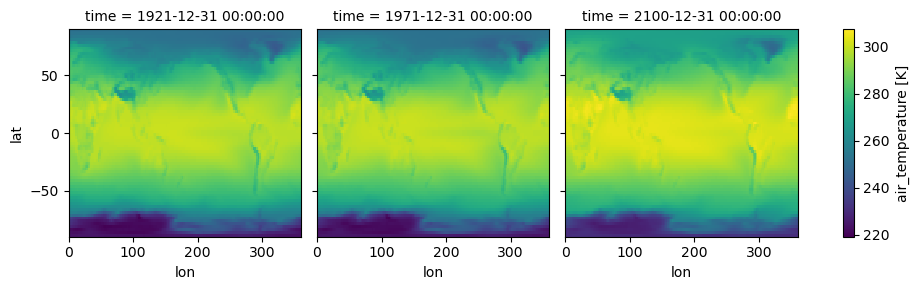

In [10]:
le_ds.isel(time=[0, 50, -1], member=20).plot(col='time')

In [11]:
le_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 180)> Size: 597MB
dask.array<transpose, shape=(40, 72, 144, 180), dtype=float64, chunksize=(40, 6, 24, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00
Attributes: (8)

<h1 style='color: cyan'> Anomalies </h1>

In [12]:
le_ds_base_period= le_ds.sel(time=slice("1920", "1949"))

In [13]:
le_ds_base_period_mean = le_ds_base_period.mean(dim='time')

In [14]:
le_anom_ds = le_ds - le_ds_base_period_mean

In [15]:
le_smean_ds = climate_utils.weighted_lat_lon_mean(le_anom_ds).compute()

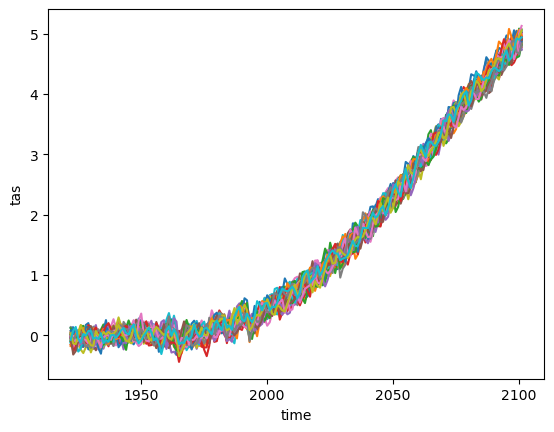

In [16]:
le_smean_ds.plot(hue='member', add_legend=False);

In [17]:
le_smean_base_period_ds = le_smean_ds.sel(time=slice("1920", "1949"))

<h1 style='color: cyan'>  Local ToE</h1>

In [18]:
window = 30

In [19]:
data_ds_window = (le_anom_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()
                 ) 

wait(data_ds_window);

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 9, 1, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 11, 5, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 9, 2, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 1, 2, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 11, 2, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 4, 3, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 3, 2, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('sliding_window_view-b5ece7f3159b5391f44ed69e0d0dd1a1', 0, 1, 0, 1, 0)>, <Future: finished,

In [20]:
data_ds_window

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 180,
                         window_dim: 30)> Size: 18GB
dask.array<sliding_window_view, shape=(40, 72, 144, 180, 30), dtype=float64, chunksize=(40, 6, 24, 179, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: window_dim

In [21]:
base_period_window_ds = (le_anom_ds.sel(time=slice('1920', '1949'))
                         .rename({'time':'window_dim'})
                         .persist()
                        )

wait(base_period_window_ds);

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 2, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 10, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 5, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 0, 3, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 10, 3, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 7, 0, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 9, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 1, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('getitem-d43acb53f3b430304b1a0dc1c69805a5', 0, 0, 2, 0)>, <Future: finished, type: numpy.nda

In [22]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

<h2 style='color: yellow'> KS Test </h2>

In [23]:
le_ds_base_period

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 29)> Size: 96MB
dask.array<getitem, shape=(40, 72, 144, 29), dtype=float64, chunksize=(40, 6, 24, 29), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 232B 1921-12-31 00:00:00 ... 1949-12-31 00:00:00
Attributes: (8)

In [26]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2min 25s, sys: 37 s, total: 3min 2s
Wall time: 5min 16s


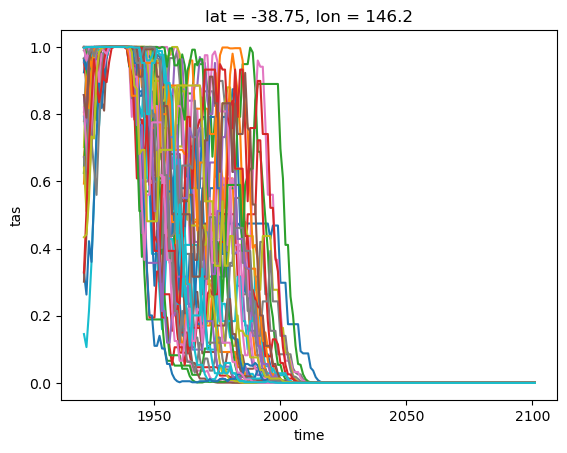

In [27]:
ks_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

<h2 style='color:yellow'>  Overlap </h2>

In [28]:
le_anom_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 180)> Size: 597MB
dask.array<sub, shape=(40, 72, 144, 180), dtype=float64, chunksize=(40, 6, 24, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 1kB 1921-12-31 00:00:00 ... 2100-12-31 00:00:00

In [29]:
# The x-values for the KDE are based upon the max and min
data_max = le_anom_ds.max().persist().values.item()
data_min = le_anom_ds.min().persist().values.item()
num_points = 1000
x = toe.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(-10.420033115080003, 22.107900509889078, (1000,))

In [30]:
toe_constants.kde_kwargs

{'bw_method': 0.2}

In [31]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    toe.create_kde_x_exists,
    le_anom_ds.sel(time=slice('1920', '1949')),
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **toe_constants.kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

<timed exec>:3: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 2.96 s, sys: 670 ms, total: 3.63 s
Wall time: 5.58 s


In [32]:
base_period_kde

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, x: 1000)> Size: 3GB
dask.array<transpose, shape=(40, 72, 144, 1000), dtype=float64, chunksize=(40, 6, 24, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
Dimensions without coordinates: x

In [33]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe.fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':toe_constants.kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

CPU times: user 4min 13s, sys: 1min 7s, total: 5min 21s
Wall time: 9min 2s


<h2 style='color: yellow'> S/N Ratio </h2>

In [34]:
local_signal_ds = xr.apply_ufunc(
    my_stats.apply_lowess, 
    le_anom_ds,#.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    kwargs=dict(window=41),
    vectorize=True, 
    dask='parallelized',   
    output_dtypes=['float']
).compute()

In [35]:
local_detrend_ds = (le_anom_ds - local_signal_ds).persist()
# local_sn_lowess_ds = (local_signal_ds/local_detrend_ds.std(dim='time')).persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 569.58 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [89]:
local_rolling_mean_signal = le_anom_ds.rolling(time=30, center=True).mean().persist();

In [46]:
local_rolling_std = local_detrend_ds.rolling(time=30, center=True).std().persist();
wait(local_rolling_std);

In [47]:
local_base_period_std = local_detrend_ds.where(
    local_detrend_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True).std(dim='time').persist()
wait(local_base_period_std);

In [48]:
local_rolling_noise = np.sqrt(1/2*(local_base_period_std**2+local_rolling_std**2))

In [90]:
local_sn_lowess_rolling_noise = (local_rolling_mean_signal/local_rolling_noise).chunk('auto').persist()
# Remove na due to end points
local_sn_lowess_rolling_noise = local_sn_lowess_rolling_noise.dropna(dim='time')

In [50]:
local_sn_lowess_ds = (local_signal_ds/local_base_period_std).chunk('auto').persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 569.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, time: 151)> Size: 501MB
dask.array<getitem, shape=(40, 72, 144, 151), dtype=float64, chunksize=(40, 24, 96, 151), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * time     (time) object 1kB 1936-12-31 00:00:00 ... 2086-12-31 00:00:00

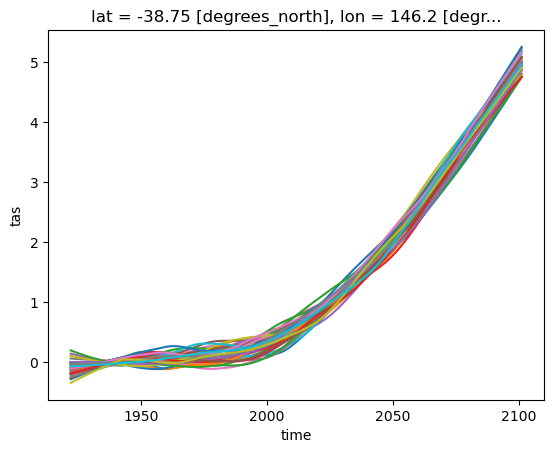

In [92]:
local_signal_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

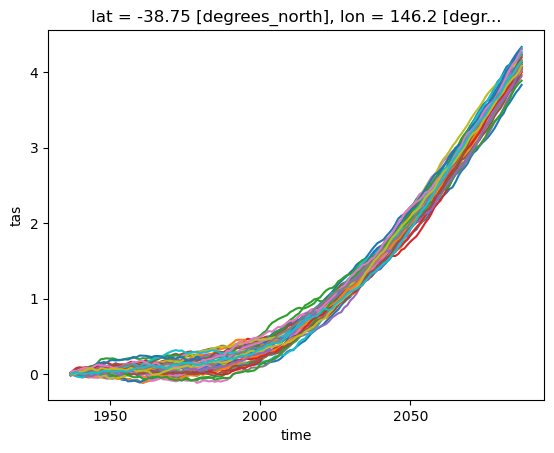

In [91]:
local_rolling_mean_signal.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

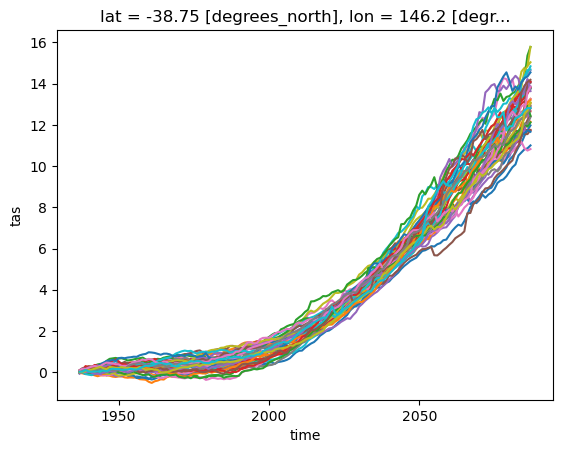

In [86]:
local_sn_lowess_rolling_noise.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

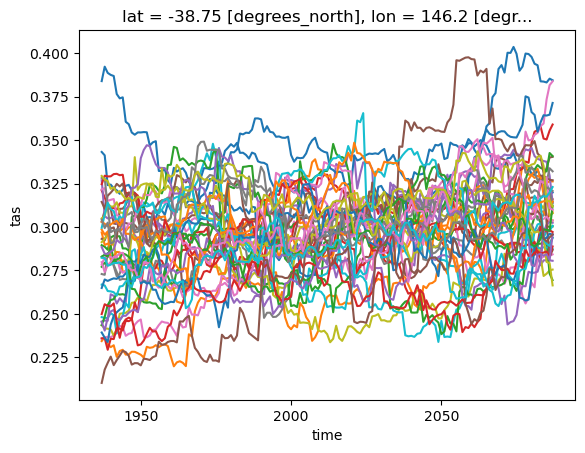

In [78]:
local_rolling_noise.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

<h2 style='color: yellow'>  ToE </h2>

In [160]:
def toe_multi_thresholds(ds, thresholds, comparison_func=np.greater):
    """
    Compute the permanent exceedance Time of Emergence (ToE) for multiple thresholds.

    Parameters:
    - ds (xarray.Dataset): The input dataset.
    - thresholds (list or array): List of threshold values.
    - comparison_func (function, optional): The comparison function (e.g., np.greater, np.less).

    Returns:
    - xarray.Dataset: Dataset with 'threshold' as a coordinate.
    """
    results = []

    for threshold in thresholds:
        result = toe.get_permanent_exceedance(ds, threshold=threshold, comparison_func=comparison_func).compute()
        results.append(result)

    return xr.concat(results, dim=xr.DataArray(thresholds, dims="threshold", name="threshold"))

In [162]:
# Example usage:
sn_multi_toe = toe_multi_thresholds(local_sn_lowess_ds, thresholds = [1, 2, 3, 5], comparison_func=np.greater)

In [164]:
overlap_multi_toe = toe_multi_thresholds(frac_geom_ds, thresholds = [62, 32, 13], comparison_func=np.less)

In [167]:
overlap_multi_toe

<xarray.DataArray 'tas' (threshold: 3, member: 40, lat: 72, lon: 144)> Size: 10MB
array([[[[1995., 1997., 1994., ..., 1994., 1994., 1994.],
         [1979., 1981., 1981., ..., 1979., 1979., 1979.],
         [1981., 1982., 1983., ..., 1982., 1982., 1982.],
         ...,
         [1992., 1992., 1992., ..., 1988., 1990., 1992.],
         [1990., 1990., 1990., ..., 1989., 1989., 1990.],
         [1990., 1990., 1990., ..., 1989., 1990., 1990.]],

        [[1986., 1986., 1978., ..., 1975., 1975., 1975.],
         [1973., 1975., 1974., ..., 1978., 1975., 1973.],
         [1991., 1990., 1988., ..., 1991., 1991., 1991.],
         ...,
         [1996., 1996., 1995., ..., 1998., 1998., 1997.],
         [1994., 1994., 1993., ..., 1995., 1995., 1994.],
         [1994., 1994., 1993., ..., 1994., 1994., 1994.]],

        [[1978., 1978., 1978., ..., 1978., 1978., 1978.],
         [1964., 1965., 1978., ..., 1964., 1964., 1963.],
         [1982., 1978., 1971., ..., 1985., 1985., 1984.],
         ...,
...
         ...,
         [2035., 2036., 2036., ..., 2027., 2028., 2028.],
         [2027., 2028., 2028., ..., 2027., 2027., 2027.],
         [2027., 2027., 2027., ..., 2027., 2027., 2027.]],

        [[2029., 2029., 2029., ..., 2029., 2029., 2029.],
         [2022., 2022., 2029., ..., 2023., 2029., 2022.],
         [2022., 2022., 2022., ..., 2022., 2022., 2022.],
         ...,
         [2032., 2032., 2032., ..., 2032., 2032., 2032.],
         [2029., 2029., 2029., ..., 2029., 2029., 2029.],
         [2029., 2029., 2029., ..., 2029., 2029., 2029.]],

        [[2032., 2032., 2032., ..., 2032., 2032., 2032.],
         [2036., 2032., 2032., ..., 2036., 2036., 2036.],
         [2032., 2032., 2032., ..., 2036., 2033., 2032.],
         ...,
         [2014., 2014., 2014., ..., 2013., 2014., 2014.],
         [2012., 2012., 2012., ..., 2012., 2012., 2012.],
         [2005., 2005., 2005., ..., 2003., 2003., 2003.]]]])
Coordinates:
  * lat        (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member     (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
  * threshold  (threshold) int64 24B 62 32 13

In [51]:
local_toe_sn_1 = toe.get_permanent_exceedance(
    local_sn_lowess_ds, threshold=1, comparison_func=np.greater).compute()

In [93]:
local_toe_sn_rolling_1 = toe.get_permanent_exceedance(
    local_sn_lowess_rolling_noise, threshold=1, comparison_func=np.greater).compute()

In [54]:
local_toe_fga = toe.get_permanent_exceedance(
    frac_geom_ds, threshold=62, comparison_func=np.less).compute()

In [55]:
local_toe_toe = toe.get_permanent_exceedance(
    ks_ds, threshold=0.01, comparison_func=np.less).compute()

In [130]:
local_toe_ks.name = 'ks'
local_toe_sn_1.name = 'sn'
local_toe_sn_rolling_1.name = 'sn_rolling'
local_toe_fga.name = 'frac'

In [141]:
toe_ds = xr.merge([local_toe_sn_1,local_toe_sn_rolling_1, local_toe_ks, local_toe_fga])
toe_ds

<xarray.Dataset> Size: 13MB
Dimensions:     (lat: 72, lon: 144, member: 40)
Coordinates:
  * lat         (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon         (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member      (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
Data variables:
    sn          (member, lat, lon) float64 3MB 1.994e+03 1.994e+03 ... 1.984e+03
    sn_rolling  (member, lat, lon) float64 3MB 1.99e+03 1.99e+03 ... 1.984e+03
    ks          (member, lat, lon) float64 3MB 1.986e+03 1.986e+03 ... 1.984e+03
    frac        (member, lat, lon) float64 3MB 1.995e+03 1.997e+03 ... 1.984e+03

<h1 style='color:cyan'> Plots </h1>

In [142]:
import cartopy.crs as ccrs
import itertools
import toe_plots
import plotting_utils

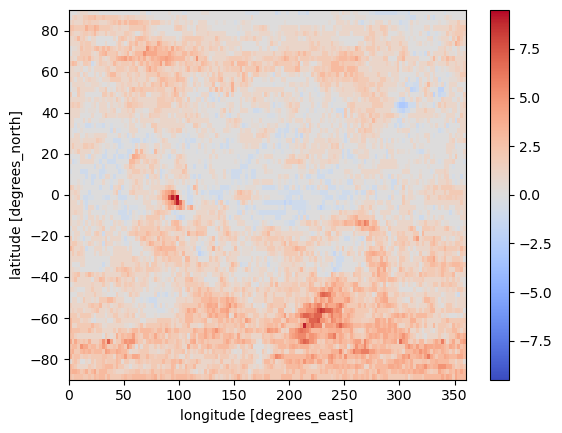

In [143]:
(local_toe_sn_1 - local_toe_ks).median(dim='member').plot(cmap='coolwarm')


In [193]:
import seaborn as sns

In [212]:
sns.color_palette?

Signature: sns.color_palette(palette=None, n_colors=None, desat=None, as_cmap=False)
Docstring:
Return a list of colors or continuous colormap defining a palette.

Possible ``palette`` values include:
    - Name of a seaborn palette (deep, muted, bright, pastel, dark, colorblind)
    - Name of matplotlib colormap
    - 'husl' or 'hls'
    - 'ch:<cubehelix arguments>'
    - 'light:<color>', 'dark:<color>', 'blend:<color>,<color>',
    - A sequence of colors in any format matplotlib accepts

Calling this function with ``palette=None`` will return the current
matplotlib color cycle.

This function can also be used in a ``with`` statement to temporarily
set the color cycle for a plot or set of plots.

See the :ref:`tutorial <palette_tutorial>` for more information.

Parameters
----------
palette : None, string, or sequence, optional
    Name of palette or None to return current palette. If a sequence, input
    colors are used but possibly cycled and desaturated.
n_colors : int, optional
 

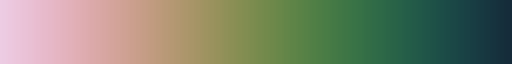

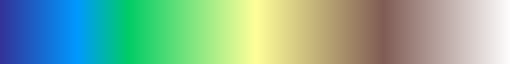

In [240]:
year_levels = np.arange(1950, 2110, 10)
uncertainty_levels = np.arange(0, 35, 5)
# cmap_years = sns.color_palette("cubehelix", as_cmap=True)
cmap_years = sns.color_palette("terrain", as_cmap=True)
#sns.cubehelix_palette(start=.1, rot=-1, as_cmap=True)
#sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
#sns.color_palette("flare", as_cmap=True)
# plt.cm.cubehelix#terrain
cmap_uncertainty = plt.cm.YlGnBu
cmap_years

In [241]:
sn_thresholds = [1,2,3]
overlap_thresholds = [62, 32, 13]

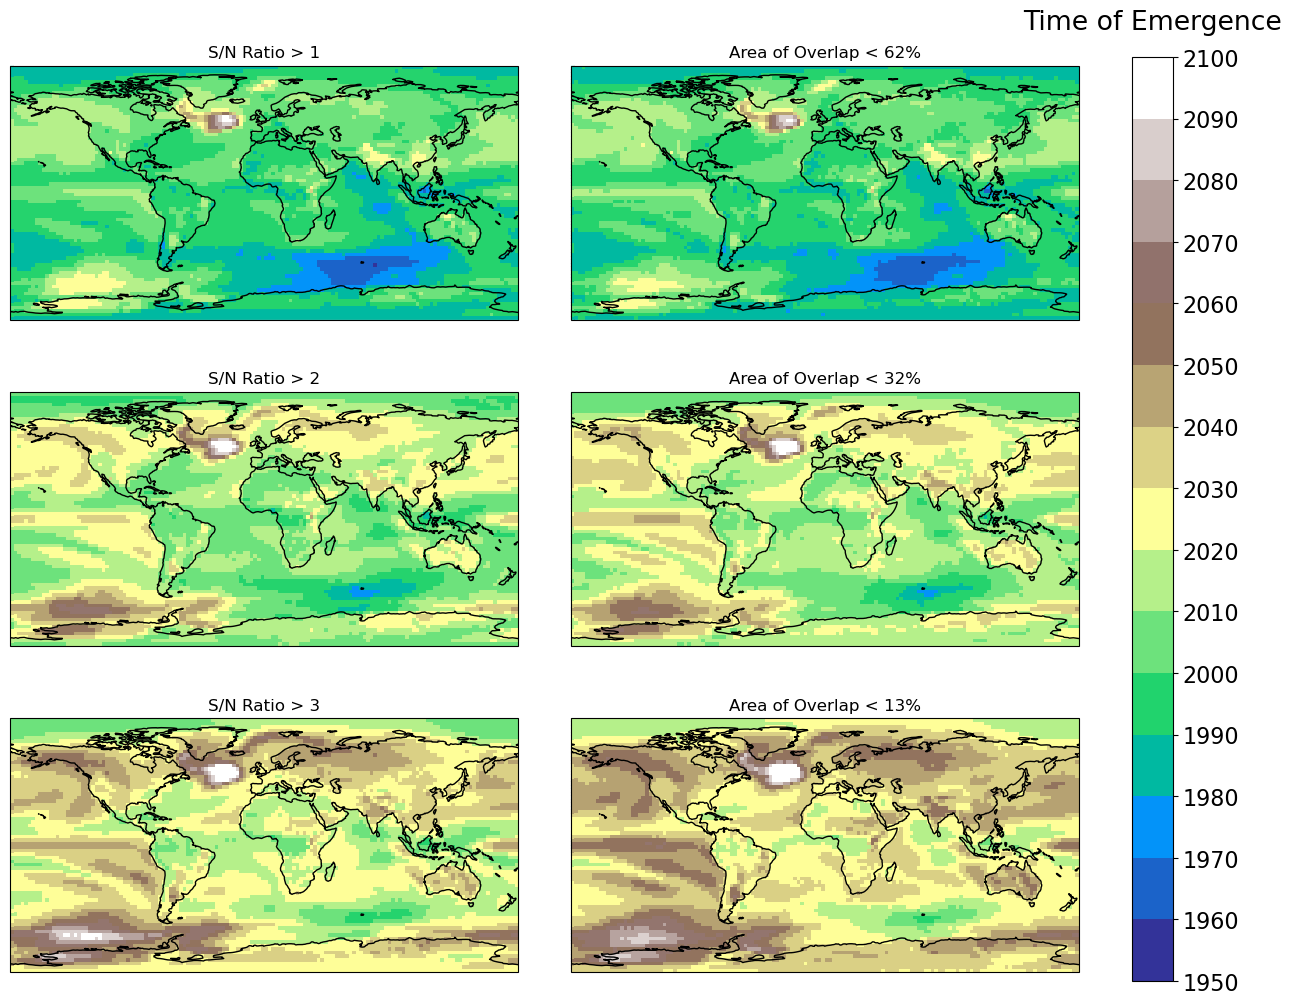

In [242]:
fontscale = 1.6
metrics_to_use = list(toe_ds)
n_metrics = len(metrics_to_use)

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(len(overlap_thresholds), 3, wspace=0.15, width_ratios=[1, 1, 0.08])

cax = plt.subplot(gs[:, -1])

axes = []

for num in range(len(sn_thresholds)): 

    axes_row = [fig.add_subplot(gs[num, i], projection=ccrs.PlateCarree()) for i in range(2)]

    sn_threshold = sn_thresholds[num]
    overlap_threshold = overlap_thresholds[num]
    
    sn_multi_toe.sel(threshold=sn_threshold).median(dim='member').plot(ax=axes_row[0], levels=year_levels, cmap=cmap_years, add_colorbar=False)
    overlap_multi_toe.sel(threshold=overlap_threshold).median(dim='member').plot(ax=axes_row[1], levels=year_levels, cmap=cmap_years, add_colorbar=False)


    plotting_utils.add_lat_markers(axes_left[num], side='right', fontscale=fontscale)
    plotting_utils.add_lat_markers(axes_right[num], side='right', fontscale=fontscale)
    axes_left[num].annotate(
            toe_plots.METRIC_MAP.get(metric, metric),
            xy=(-0.1, 0.5), xycoords = 'axes fraction',
            rotation=90, ha='center', va='center', fontsize=14*fontscale)

    axes_row[0].set_title(f'S/N Ratio > {sn_threshold}')
    axes_row[1].set_title(f'Area of Overlap < {overlap_threshold}%')

    axes.extend(axes_row)
    
[ax.coastlines() for ax in axes];

# Create colorbars
cbar1 = plotting_utils.create_discrete_colorbar(
    cmap_years, year_levels, cax, 'Time of Emergence',fontscale=fontscale)


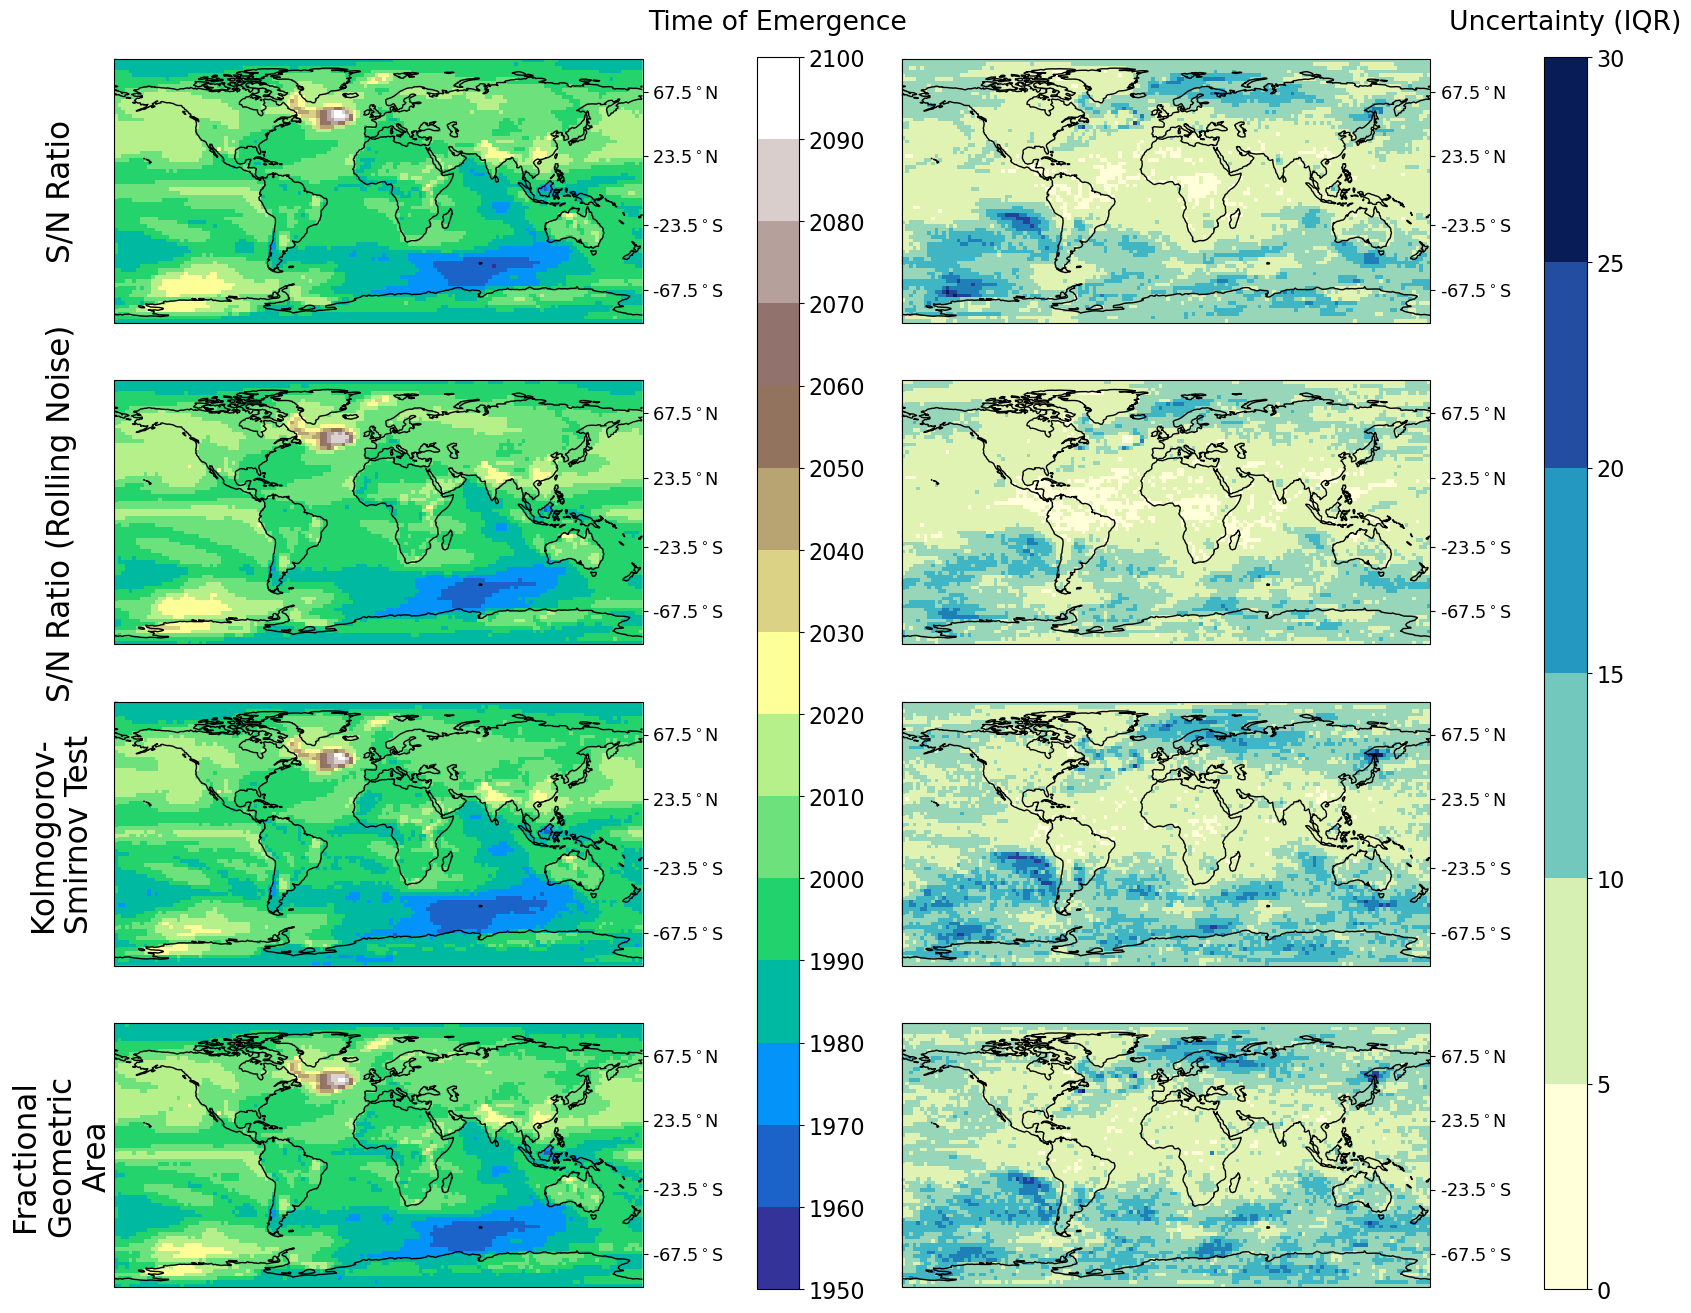

In [243]:
fontscale = 1.6
metrics_to_use = list(toe_ds)
n_metrics = len(metrics_to_use)

fig = plt.figure(figsize=(19, 16))
gs = gridspec.GridSpec(1, 2, wspace=0.15)

gs_kwargs = dict(width_ratios=[1, 0.08], wspace=0.4)
gs_left = gridspec.GridSpecFromSubplotSpec(n_metrics, 2, subplot_spec=gs[0], **gs_kwargs)
gs_right = gridspec.GridSpecFromSubplotSpec(n_metrics, 2, subplot_spec=gs[1], **gs_kwargs)


caxes = [plt.subplot(gs_left[:, 1]), plt.subplot(gs_right[:, 1])]

axes_left, axes_right = zip(*[
    (fig.add_subplot(gs_left[row, 0], projection=ccrs.PlateCarree()),
     fig.add_subplot(gs_right[row, 0], projection=ccrs.PlateCarree()))
    for row in range(n_metrics)
])
year_levels = np.arange(1950, 2110, 10)
uncertainty_levels = np.arange(0, 35, 5)
cmap_years = plt.cm.terrain
cmap_uncertainty = plt.cm.YlGnBu

for num,metric in enumerate(metrics_to_use): 

    toe_ds[metric].median(dim='member').plot(ax=axes_left[num], levels=year_levels, cmap=cmap_years, add_colorbar=False)
    
    (toe_ds[metric].quantile(0.75, dim='member')-toe_ds[metric].quantile(0.25, dim='member')
        ).plot(ax=axes_right[num], levels=uncertainty_levels, cmap=cmap_uncertainty, extend='max', add_colorbar=False)


    plotting_utils.add_lat_markers(axes_left[num], side='right', fontscale=fontscale)
    plotting_utils.add_lat_markers(axes_right[num], side='right', fontscale=fontscale)
    axes_left[num].annotate(
            toe_plots.METRIC_MAP.get(metric, metric),
            xy=(-0.1, 0.5), xycoords = 'axes fraction',
            rotation=90, ha='center', va='center', fontsize=14*fontscale)
    
[ax.coastlines() for ax in [*axes_left, *axes_right]];

# Create colorbars
cbar1 = plotting_utils.create_discrete_colorbar(
    cmap_years, year_levels, caxes[0], 'Time of Emergence',fontscale=fontscale)

cbar2 = plotting_utils.create_discrete_colorbar(
    cmap_uncertainty, uncertainty_levels, caxes[1], 'Uncertainty (IQR)',fontscale=fontscale)

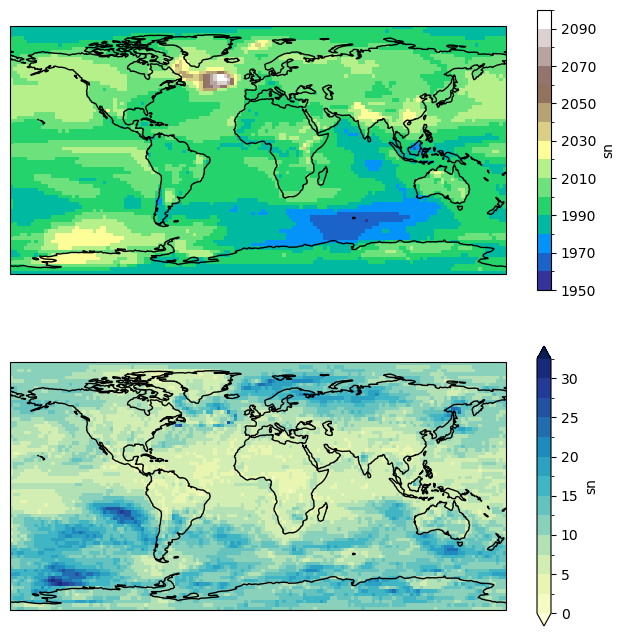

In [148]:
fig = plt.figure(figsize=(8, 8))

gs = gridspec.GridSpec(2, 1)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(2)]


year_levels = np.arange(1950, 2110, 10)

local_toe_sn_1.median(dim='member').plot(ax=axes[0], levels=year_levels, cmap='terrain')

(local_toe_sn_1.quantile(0.75, dim='member')-local_toe_sn_1.quantile(0.25, dim='member')
    ).plot(ax=axes[-1], levels=np.arange(0, 35, 2.5), cmap='YlGnBu', extend='both')

[ax.coastlines() for ax in axes]

In [150]:
west_pacific_loc = dict(lat=-22.60, lon=-112.21, method='nearest')
central_africa_loc = dict(lat=7.76, lon=-20.89, method='nearest')

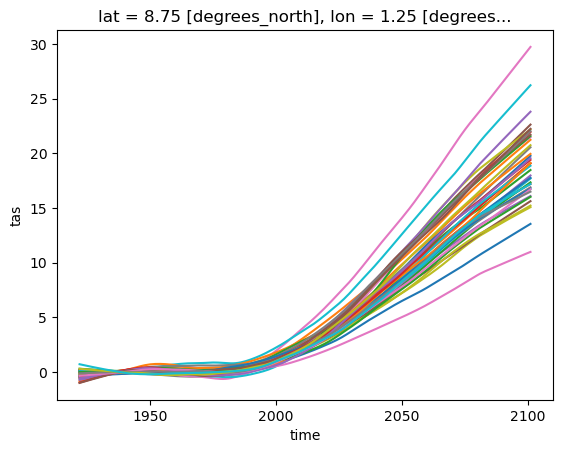

In [151]:
local_sn_lowess_ds.sel(**central_africa_loc).plot(hue='member', add_legend=False);

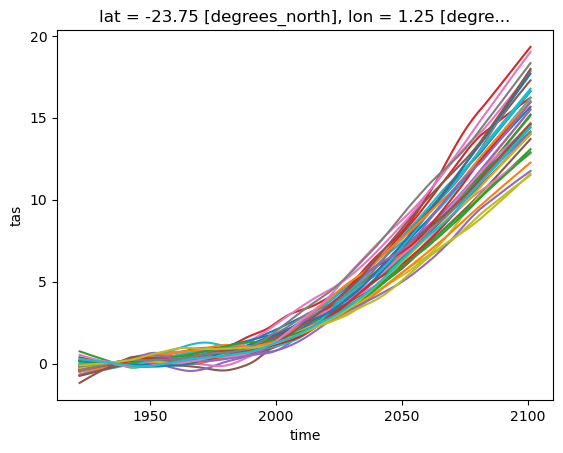

In [152]:
local_sn_lowess_ds.sel(**west_pacific_loc).plot(hue='member', add_legend=False);

In [155]:
# iqr_sereies = local_sn_lowess_ds.quantile(0.75, dim='member') - local_sn_lowess_ds.quantile(0.25, dim='member')
# iqr_sereies.sel(**west_pacific_loc).plot(label='ep')
# iqr_sereies.sel(**central_africa_loc).plot(label='cent afr')
# plt.legend()

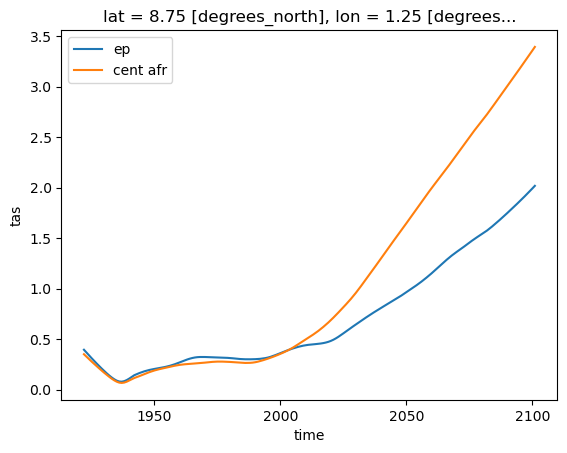

In [156]:
local_sn_lowess_ds.sel(**west_pacific_loc).std(dim='member').plot(label='ep')
local_sn_lowess_ds.sel(**central_africa_loc).std(dim='member').plot(label='cent afr')
plt.legend()

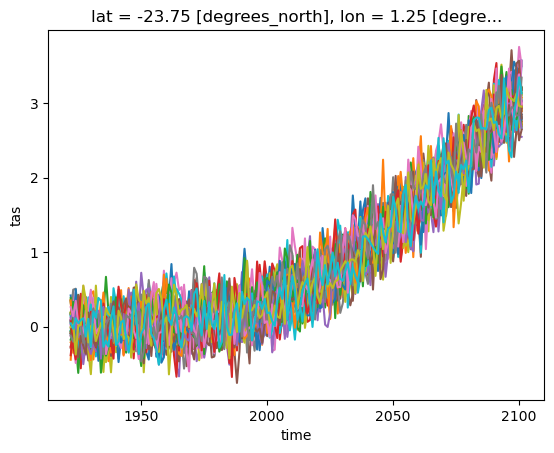

In [158]:
le_anom_ds.sel(**west_pacific_loc).plot(hue='member', add_legend=False);

# Misc

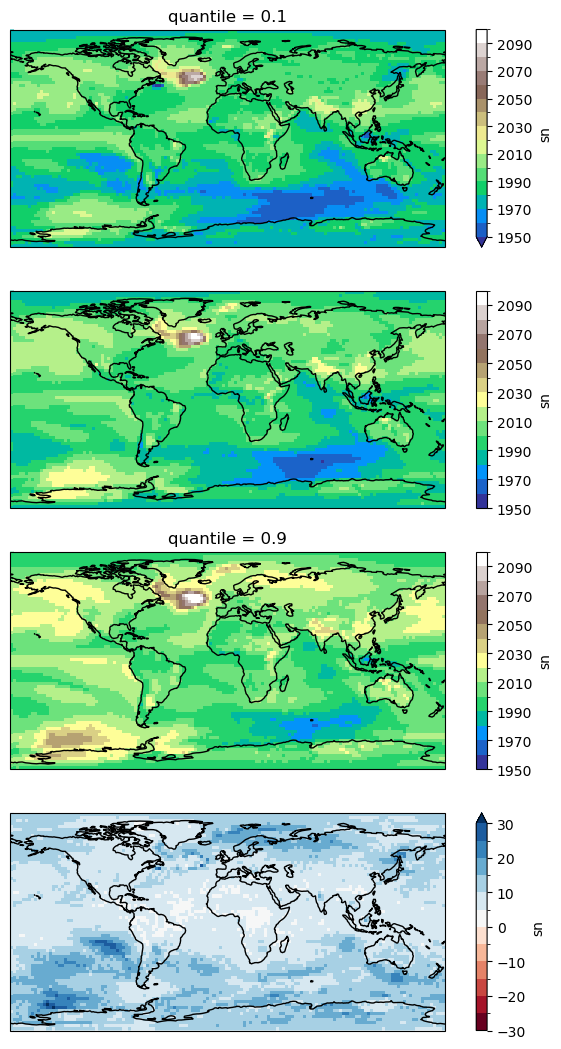

In [159]:
fig = plt.figure(figsize=(8, 13))

gs = gridspec.GridSpec(4, 1)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(4)]


year_levels = np.arange(1950, 2110, 10)

local_toe_sn_1.median(dim='member').plot(ax=axes[1], levels=year_levels, cmap='terrain')
local_toe_sn_1.quantile(0.1, dim='member').plot(ax=axes[0], levels=year_levels, cmap='terrain')
local_toe_sn_1.quantile(0.9, dim='member').plot(ax=axes[2], levels=year_levels, cmap='terrain')

(local_toe_sn_1.quantile(0.75, dim='member')-local_toe_sn_1.quantile(0.25, dim='member')
    ).plot(ax=axes[3], levels=np.arange(-30, 35, 5), cmap='RdBu')



[ax.coastlines() for ax in axes]

In [ ]:
local_toe_sn_1.median(dim='member').plot()

In [ ]:
local_toe_sn_1.min(dim='member').plot()

In [ ]:
local_toe_sn_5.min().values.item(), local_toe_sn_5.median().values.item(), local_toe_sn_5.max().values.item()

In [ ]:
fig, ax = plt.subplots()
local_sn_lowess_ds.plot(hue='member', add_legend=False);
ax.axhline(3)

In [ ]:
local_signal_ds.plot(hue='member', add_legend=False);

In [ ]:
def compute_pct_emergence(toe_values, percentile=50):
    """
    Determines the interpolated year when 50% of ensemble members have emerged.
    
    Parameters:
    toe_values (list or np.array): Array of emergence years, with NaN for non-emerging members.
    
    Returns:
    float: Interpolated year when 50% of members have emerged, or NaN if fewer than 50% emerge.
    """
    toe_values = np.array(toe_values)
    N_threshold = percentile/100 * len(toe_values)  # 50% threshold
    valid_toe = np.sort(toe_values[~np.isnan(toe_values)])
    
    if len(valid_toe) < np.ceil(N_threshold): return np.nan
    
    idx = N_threshold - 1  # 0-based index

    # This occurs when t
    if idx.is_integer():
        return valid_toe[int(idx)]
    
    lower = valid_toe[int(idx)]
    upper = valid_toe[int(idx) + 1]
    weight = idx - int(idx)
    interpolated_value = lower + weight * (upper - lower)
    
    return interpolated_value

In [ ]:
local_toe_sn_5.values.copy()

In [ ]:
np.median(local_toe_sn_5.values.copy())

In [ ]:
toe_values = local_toe_sn_5.values.copy()
toe_values_edit = toe_values.copy()
max_value = 2043
toe_values_edit[toe_values_edit>max_value] = max_value#np.nan
toe_values_edit

In [ ]:
local_toe_sn_5.min().values.item(), local_toe_sn_5.max().values.item()

In [ ]:
np.sum(toe_values>max_value)

In [ ]:
compute_pct_emergence(toe_values, 50)

In [ ]:
compute_pct_emergence(toe_values_edit, 50)

In [ ]:
# Example Usage
toe_example = [2040, 2035, 2025, np.nan, 2030, 2045, 2038, np.nan, 2032, 2037, np.nan, np.nan]
result = compute_pct_emergence(toe_example)
print("50% Emergence Year:", result)

# GMST

## S/N Ratio

In [ ]:
le_smean_signal_ds = xr.apply_ufunc(
    my_stats.apply_lowess, 
    le_smean_ds,#.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    kwargs=dict(window=41),
    vectorize=True, 
    dask='parallelized',    
).compute()

In [ ]:
le_smean_detrend_ds = le_smean_ds - le_smean_signal_ds

In [ ]:
rolling_std = le_smean_detrend_ds.rolling(time=30, center=True).std();

In [ ]:
baes_period_std = le_smean_base_period_ds.std(dim='time')

In [ ]:
rolling_noise = np.sqrt(1/2*(baes_period_std**2+rolling_std**2))

In [ ]:
ds_smean_sn_lowess_rolling_noise = le_smean_signal_ds/rolling_noise

In [ ]:
ds_smean_sn_lowess = le_smean_signal_ds/le_smean_detrend_ds.std(dim='time')

In [ ]:
ds_smean_sn_lowess_rolling_noise.plot(hue='member', add_legend=False);

In [ ]:
ds_smean_sn_lowess.plot(hue='member', add_legend=False);

## KS test

In [ ]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [ ]:
window = 30

In [ ]:
data_ds_window = (le_smean_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                 ) 

base_period_window_ds = (le_smean_ds.where(le_smean_ds.time.dt.year.isin(np.arange(1920, 1950)), drop=True)
                         .rename({'time':'window_dim'})
                        )

In [ ]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

frac_geom_ds = xr.apply_ufunc(
    toe.fractional_geometric_area,
    data_ds_window,
    base_period_window_ds,
    kwargs = dict(method_kwargs=kde_kwargs),
    output_dtypes=['float'],
    **rolling_window_kwargs
    ).compute()

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

## Comparisons

In [ ]:
import toe_constants

In [ ]:
toe_constants.ThresholdProfileLow.overlap_threshold

In [ ]:
toe_fga = toe.get_permanent_exceedance(frac_geom_ds, threshold=62, comparison_func=np.less)

In [ ]:
ds_smean_sn_lowess_rolling_noise

In [ ]:
toe_sn_rolling_1 = toe.get_permanent_exceedance(ds_smean_sn_lowess_rolling_noise.dropna(dim='time'), threshold=1, comparison_func=np.greater)

In [ ]:
toe_sn_rolling_1

In [ ]:
toe_sn_1 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=1, comparison_func=np.greater)
toe_sn_2 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=2, comparison_func=np.greater)
toe_sn_3 = toe.get_permanent_exceedance(ds_smean_sn_lowess, threshold=3, comparison_func=np.greater)

In [ ]:
toe_ks = toe.get_permanent_exceedance(ks_ds, threshold=0.01, comparison_func=np.less)
toe_ttest = toe.get_permanent_exceedance(ttest_ds, threshold=0.01, comparison_func=np.less)

In [ ]:
sn_toe_diff = toe_sn_1 - toe_ks
sn_toe_diff_sorted = sn_toe_diff.sortby(np.abs(sn_toe_diff), ascending=False)

In [ ]:
np.median(np.abs(sn_toe_diff))

In [ ]:
largest_diff = sn_toe_diff_sorted.isel(member=0)# .member.values.item()
smallest_diff = sn_toe_diff_sorted.isel(member=-1)

In [ ]:
largest_diff

In [ ]:
fig, ax = plt.subplots(1, 1)

ds_smean_sn_lowess.sel(member=largest_diff.member.values.item()).plot(ax=ax)
ax.axhline(1, color='grey', linestyle='--')

ax2 = ax.twinx()
ks_ds.sel(member=largest_diff.member.values.item()).plot(ax=ax2)
ax2.axhline(0.01, linestyle='--', color='red')

In [ ]:
fig, ax = plt.subplots(1, 1)

ds_smean_sn_lowess.sel(member=smallest_diff.member.values.item()).plot(ax=ax)
ax.axhline(1, color='grey', linestyle='--')

ax2 = ax.twinx()
ks_ds.sel(member=smallest_diff.member.values.item()).plot(ax=ax2)
ax2.axhline(0.01, linestyle='--', color='red')

In [ ]:
le_smean_ds.sel(member=largest_diff.member.values.item()).plot()

In [ ]:
le_anom_ds

In [ ]:
np.std(toe_sn_1), np.std(toe_sn_2), np.std(toe_sn_3)

In [ ]:
toe_sn_1.min(), toe_sn_1.max()

In [ ]:
np.median(toe_ks), np.std(toe_ks)

In [ ]:
np.median(toe_sn_1), np.median(toe_sn_2), np.median(toe_sn_3)

In [ ]:
xdiff, sn_toe_diff_kde = toe.create_kde(sn_toe_diff)

In [ ]:
plt.plot(xdiff, sn_toe_diff_kde)

In [ ]:
x = np.linspace(1930, 2030, 700)

In [ ]:
toe_fga

In [ ]:
_, kde_toe_fga = toe.create_kde(toe_fga, x)

In [ ]:
_, kde_toe_rolling_1 = toe.create_kde(toe_sn_rolling_1, x)

In [ ]:
_, kde_toe_sn1 = toe.create_kde(toe_sn_1, x)
_, kde_toe_sn2 = toe.create_kde(toe_sn_2, x)
_, kde_toe_sn3 = toe.create_kde(toe_sn_3, x)

_, kde_toe_ks = toe.create_kde(toe_ks, x)
_, kde_toe_ttest = toe.create_kde(toe_ttest, x)

In [ ]:
from toe_plots import test_colors

In [ ]:
test_colors

In [ ]:
# Compute medians of the original data used to generate the KDEs
median_sn1 = np.median(toe_sn_1)
median_ks = np.median(toe_ks)
median_ttest = np.median(toe_ttest)

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with enhanced aesthetics
ax.plot(x, kde_toe_fga, label='FGA', color=test_colors['frac'], linewidth=2.5, linestyle='-')

ax.plot(x, kde_toe_sn1, label='S/N Ratio', color=test_colors['sn_lowess_base'], linewidth=2.5, linestyle='-')
ax.plot(x, kde_toe_rolling_1, label='S/N Ratio Rolling', color='green', linewidth=2.5, linestyle='-')

ax.plot(x, kde_toe_ks, label='KS Test', color=test_colors['ks'], linewidth=2.5)
ax.plot(x, kde_toe_ttest, label='T-Test', color=test_colors['ttest'], linewidth=2.5)


# Set limits
ax.set_xlim(1930, 2000)
ax.set_ylim(-0.0001, 0.11)

# Add labels with styling
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=14, fontweight='bold')

# Customizing grid and ticks
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=12)

# Enhanced legend
ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(x, kde_toe_sn1, label='S/N Ratio')
ax.plot(x, kde_toe_ks, label='KS')
ax.plot(x, kde_toe_ttest, label='T-Test')

ax.set_xlim(1930, 2000)

ax.set_ylim(-0.0001, 0.11)

In [ ]:
plt.plot(x1, kde_toe_sn1)
plt.plot(x4, kde_toe_ks)
plt.plot(x5, kde_toe_ttest)


plt.plot(x2, kde_toe_sn2)
plt.plot(x3, kde_toe_sn3)

# CEEMDAN

In [ ]:
from PyEMD import CEEMDAN

In [ ]:
ceedman = CEEMDAN(trials=500)

In [ ]:
def return_residual(arr):

    imf_arr = ceedman(arr)

    return imf_arr[-1, :]

In [ ]:
def return_all_imf(arr, n_imfs=3):

    imf_arr = ceedman(arr)

    return imf_arr[-n_imfs:, :]

In [ ]:
n_imfs = 3

In [ ]:
le_smean_ds_ens_mean = le_smean_ds.mean(dim='member').compute()

In [ ]:
imf_ds = xr.apply_ufunc(
    return_all_imf,
    le_smean_ds.isel(time=slice(None, -20)).chunk({'member':1}),
    input_core_dims=[['time']], 
    output_core_dims=[['imf', 'time']],
    kwargs = {'n_imfs':n_imfs},
    dask_gufunc_kwargs={'output_sizes': {'imf': 3}},
    vectorize=True,
    dask='parallelized',
    output_dtypes=['float']
).compute()

In [ ]:
imf_ds = imf_ds.assign_coords(imf=('imf', np.arange(n_imfs)))

In [ ]:
potential_series = imf_ds.isel(imf=slice(-2, None)).sum(dim='imf')
# potential_series = imf_ds.isel(imf=-1)

In [ ]:
np.mean((((le_smean_signal_ds - le_smean_ds_ens_mean).values)**2)**(0.5))

In [ ]:
np.mean((((potential_series - le_smean_ds_ens_mean).values)**2)**(0.5))

In [ ]:
le_smean_signal_ds.plot(hue='member', add_legend=False);
le_smean_ds_ens_mean.plot(color='k')

In [ ]:
potential_series.plot(hue='member', add_legend=False);
le_smean_ds_ens_mean.plot(color='k')

In [ ]:
nplots = len(imf_ds.member.values)

ncols = 4
nrows = nplots // ncols + 1

fig = plt.figure(figsize=(16, 30))
gs = gridspec.GridSpec(nrows, ncols)

axes = [fig.add_subplot(gs[i]) for i in range(nplots)]


for num in range(nplots):
    ax = axes[num]

    ax.plot(potential_series.time.values, potential_series.isel(member=num).values)
    ax.plot(le_smean_ds.time.values, le_smean_ds.isel(member=num).values, alpha=0.5)